In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import gzip  
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve
pd.options.display.max_columns = None # display all columns
mpl.rcParams['figure.dpi'] = 150 # Make plots bigger
from imblearn.under_sampling import NearMiss


n = 40428967  #total number of records in the clickstream data 
sample_size = 100000
skip_values = sorted(random.sample(range(1,n), n-sample_size))
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
with gzip.open('train.gz') as f:
    data = pd.read_csv(f, parse_dates = ['hour'], date_parser = parse_date, skiprows = skip_values)


Using TensorFlow backend.


In [3]:
data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10197730649671218638,0,2014-10-21,1005,1,0a742914,510bd839,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,583a3354,236330a4,1,0,19772,320,50,2227,0,687,100079,48
1,10382470462203832576,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,8664d73c,711ee120,1,0,15699,320,50,1722,0,35,100084,79
2,10455448595439357179,0,2014-10-21,1005,0,6c5b482c,7687a86e,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,9de37c65,a02e0266,1,0,20345,300,250,2331,2,39,-1,23
3,10761806693636361147,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,a48a2f3f,c6263d8a,1,0,15705,320,50,1722,0,35,-1,79
4,10845120183239267814,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,8299c472,cc1e3ed4,1,0,15703,320,50,1722,0,35,-1,79


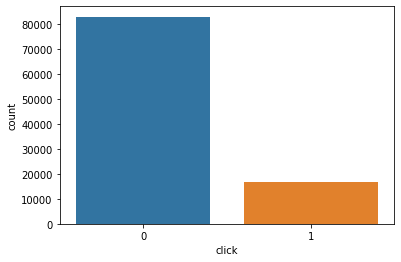

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 


sns.countplot(x='click',data=data)
plt.show()

In [5]:
data['click'].value_counts()/len(data)

0    0.83053
1    0.16947
Name: click, dtype: float64

In [6]:
data.describe()

,id,click,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.000000
mean,9.231148e+18,0.169470,1004.970800,0.286750,1.016620,0.334780,18827.812790,318.951040,59.844680,2111.06351,1.42963,227.435710,53007.078110,83.428260
std,5.328256e+18,0.375168,1.112124,0.508042,0.534478,0.858283,4978.119365,21.269664,46.700058,611.17776,1.32788,350.661815,49969.915325,70.184056
min,1.441823e+13,0.000000,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.00000,0.00000,33.000000,-1.000000,1.000000
25%,4.611897e+18,0.000000,1005.000000,0.000000,1.000000,0.000000,16859.000000,320.000000,50.000000,1835.00000,0.00000,35.000000,-1.000000,23.000000
50%,9.213765e+18,0.000000,1005.000000,0.000000,1.000000,0.000000,20346.000000,320.000000,50.000000,2323.00000,2.00000,39.000000,100037.000000,61.000000
75%,1.385012e+19,0.000000,1005.000000,1.000000,1.000000,0.000000,21894.000000,320.000000,50.000000,2526.00000,3.00000,175.000000,100093.000000,101.000000
max,1.844662e+19,1.000000,1012.000000,7.000000,5.000000,5.000000,24043.000000,1024.000000,1024.000000,2757.00000,3.00000,1839.000000,100248.000000,255.000000


In [2]:
data['hour_of_day'] = data.hour.apply(lambda x: x.hour)
data['day_of_week'] = data.hour.apply(lambda x: x.weekday_name)

C:\Users\cl1888\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  


In [3]:
# Drop ID
drops = ['id', 'hour', 'device_id', 'device_ip']
data = data.drop(drops, axis = 1)

In [7]:
data.dtypes

click                int64
C1                   int64
banner_pos           int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_model        object
device_type          int64
device_conn_type     int64
C14                  int64
C15                  int64
C16                  int64
C17                  int64
C18                  int64
C19                  int64
C20                  int64
C21                  int64
hour_of_day          int64
day_of_week         object
dtype: object

In [8]:
data.agg('nunique')

click                  2
C1                     7
banner_pos             7
site_id             1480
site_domain         1361
site_category         20
app_id              1302
app_domain            98
app_category          22
device_model        3160
device_type            4
device_conn_type       4
C14                 1710
C15                    8
C16                    9
C17                  394
C18                    4
C19                   64
C20                  156
C21                   60
hour_of_day           24
day_of_week            7
dtype: int64

In [4]:
msk = np.random.rand(len(data)) < 0.8

train = data[msk]

test = data[~msk]


def convert_obj_to_int(self):
    
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] == object :
            self[object_list_columns[index]+new_col_suffix] = self[object_list_columns[index]].map( lambda  x: hash(x))
            self.drop([object_list_columns[index]], inplace=True,axis=1)
    return self


X_train = train.loc[:, train.columns != 'click']
X_train = X_train.astype(str)

y_train = train.click.values

X_test = test.loc[:, train.columns != 'click']
X_test = X_test.astype(str)

y_test = test.click.values

X_train = convert_obj_to_int(X_train).to_numpy()
X_test = convert_obj_to_int(X_test).to_numpy()

undersample = NearMiss(version=3, n_neighbors_ver3=3)
X_train, y_train = undersample.fit_resample(X_train, y_train)


In [5]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 13683, 1: 13683}

In [6]:
mod1 = DecisionTreeClassifier(max_depth = None)
mod2 = RandomForestClassifier(n_estimators=100, max_depth = None)
mod3 = GradientBoostingClassifier(learning_rate=0.2, n_estimators=100)
mod4 = BaggingClassifier(max_features = 0.7)
mod1.fit(X_train, y_train)
mod2.fit(X_train, y_train)
mod3.fit(X_train, y_train)
mod4.fit(X_train, y_train)
preds1 = mod1.predict(X_test).astype(int)
preds2 = mod2.predict(X_test).astype(int)
preds3 = mod3.predict(X_test).astype(int)
preds4 = mod4.predict(X_test).astype(int)





In [7]:
from sklearn.metrics import accuracy_score

def get_metrics(y_true, y_preds):
    recall = recall_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    accuracy = accuracy_score(y_true, y_preds)
    return (recall, precision, accuracy)


In [8]:
pd.DataFrame({'Metrics':['Recall', 'Precision', 'Accuracy'],
'Mod1: Decision Tree': get_metrics(y_test, preds1),
'Mod2: Random Forest': get_metrics(y_test, preds2),
'Mod3: Boosted Decision Tree': get_metrics(y_test, preds3),
'Mod4: Bagged Decision Tree': get_metrics(y_test, preds4)})

,Metrics,Mod1: Decision Tree,Mod2: Random Forest,Mod3: Boosted Decision Tree,Mod4: Bagged Decision Tree
0,Recall,0.640734,0.586538,0.571678,0.613928
1,Precision,0.208495,0.236629,0.256437,0.234372
2,Accuracy,0.519798,0.603398,0.641189,0.588613


In [9]:
probs1 = mod1.predict_proba(X_test)
probs2 = mod2.predict_proba(X_test)
probs3 = mod3.predict_proba(X_test)
probs4 = mod4.predict_proba(X_test)
fpr1, tpr1, _ = roc_curve(y_test, probs1[:, 1])
fpr2, tpr2, _ = roc_curve(y_test, probs2[:, 1])
fpr3, tpr3, _ = roc_curve(y_test, probs3[:, 1])
fpr4, tpr4, _ = roc_curve(y_test, probs4[:, 1])
auc1 = roc_auc_score(y_test, probs1[:, 1])
auc2 = roc_auc_score(y_test, probs2[:, 1])
auc3 = roc_auc_score(y_test, probs3[:, 1])
auc4 = roc_auc_score(y_test, probs4[:, 1])


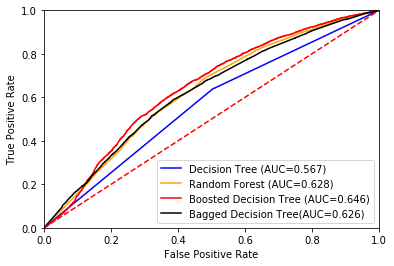

In [10]:
plt.plot(fpr1, tpr1, 'b', label = 'Decision Tree (AUC={:.3f})'.format(auc1), c='blue')
plt.plot(fpr2, tpr2, 'b', label = 'Random Forest (AUC={:.3f})'.format(auc2), c='orange')
plt.plot(fpr3, tpr3, 'b', label = 'Boosted Decision Tree (AUC={:.3f})'.format(auc3), c='red')
plt.plot(fpr4, tpr4, 'b', label = 'Bagged Decision Tree(AUC={:.3f})'.format(auc4), c='black')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [11]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth}


In [12]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2, scoring = 'f1')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 41.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [13]:
grid_search.best_params_

{'max_depth': 10, 'n_estimators': 500}

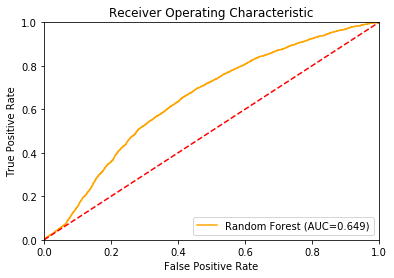

In [14]:
mod2 = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                              max_depth = grid_search.best_params_['max_depth'])
mod2.fit(X_train, y_train)
preds2 = mod2.predict(X_test)
probs2 = mod2.predict_proba(X_test)
fpr2, tpr2, _ = roc_curve(y_test, probs2[:, 1])
auc2 = roc_auc_score(y_test, probs2[:, 1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr2, tpr2, 'b', label = 'Random Forest (AUC={:.3f})'.format(auc2), c='orange')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [15]:
pd.DataFrame({'Metrics':['Recall', 'Precision', 'Accuracy'],'New Model: Random Forest': get_metrics(y_test, preds2)})

,Metrics,New Model: Random Forest
0,Recall,0.530012
1,Precision,0.267107
2,Accuracy,0.669006
